# Procesamiento de Datos Financieros - PYMES de Ibagué

## Versión 2.0 - Corrección de extracción temporal con FECHA_CORTE

**Proyecto**: Sistema Web de Análisis Financiero con Machine Learning para PYMES de Ibagué, Tolima

**Objetivo**: Ejecutar el cruce definitivo entre la Cámara de Comercio de Ibagué y los datasets SIREM, extraer los datos financieros de las PYMES identificadas, y transformarlos del formato vertical (una fila por concepto-valor) al formato horizontal (una columna por concepto contable).

### Cambios respecto a la versión 1.0

| Aspecto | v1.0 | v2.0 |
|---|---|---|
| Extracción del año fiscal | TAXONOMIA (regex, truncada para 2021+) | **FECHA_CORTE** (fecha completa) |
| Años recuperados | 2018-2020 (Balance/Resultados) | **2016-2024** (cobertura completa) |
| Filtro de PERIODO | Solo "Periodo Actual" (perdía 2016-2017) | **Filtro inteligente** (maneja formatos mixtos) |
| Encoding de CONCEPTO | Artefactos (caracteres ilegibles) | **Auto-detección** de codificación |

### Prerrequisito

Notebook `etl_camara_comercio.ipynb` completado (66 empresas identificadas, 61 NIIF Pymes).

### Entradas
- Dataset Cámara de Comercio de Ibagué (23.58 MB)
- 3 Datasets SIREM financieros: Situación Financiera (4.10 GB), Resultado Integral (1.57 GB), Flujo de Efectivo (1.43 GB)

### Salidas esperadas
- Datos financieros filtrados por empresa (formato vertical, 3 archivos CSV)
- Dataset consolidado horizontal (una fila por empresa-año, 1 archivo CSV)

In [1]:
# ==============================================================================
# IMPORTACION DE LIBRERIAS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import gc

# Configuracion general del entorno
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 60)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)

print('Librerias cargadas correctamente')

C:\Users\USUARIO1\AppData\Local\Temp\ipykernel_3252\2213692300.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Librerias cargadas correctamente


---
## 1. Configuración de Rutas y Archivos

Definimos las rutas a los datasets fuente y la carpeta de salida para los datos procesados.

In [2]:
# ==============================================================================
# RUTAS DE DATOS
# ==============================================================================

# Carpeta con los datasets originales (SIREM + Camara de Comercio)
BASE_PATH = Path('C:/Users/USUARIO1/Documents/Tesis/dataset')

# Carpeta de salida para datos procesados
SALIDA_PATH = Path('C:/Users/USUARIO1/Documents/Tesis/data')
SALIDA_PATH.mkdir(exist_ok=True)

# Archivo de la Camara de Comercio de Ibague
ARCHIVO_CAMARA = 'BASE_DE_DATOS_DE_EMPRESAS_Y_O_ENTIDADES_ACTIVAS_-_JURISDICCI\u00d3N_C\u00c1MARA_DE_COMERCIO_DE_IBAGU\u00c9_-_CORTE_A_31_DE_DICIEMBRE_DE_2025_20260207.csv'

# Archivos SIREM (3 estados financieros - se excluye Caratula por ser metadatos)
ARCHIVOS_SIREM = {
    'situacion_financiera': 'Estados_Financieros_NIIF-_Estado_de_Situaci\u00f3n_Financiera_20260203.csv',
    'resultado_integral': 'Estados_Financieros_NIIF-_Estado_de_Resultado_Integral_20260204.csv',
    'flujo_efectivo': 'Estados_Financieros_NIIF-_Estado_de_Flujo_Efectivo_20260204.csv'
}

# Verificacion de archivos
print('CONFIGURACION DE RUTAS')
print('=' * 65)
print(f'Datos fuente:    {BASE_PATH}')
print(f'Datos salida:    {SALIDA_PATH}')
print(f'\nArchivos SIREM:')
for nombre, archivo in ARCHIVOS_SIREM.items():
    ruta = BASE_PATH / archivo
    if ruta.exists():
        tamano = ruta.stat().st_size / (1024**3)
        print(f'  [OK] {nombre}: {tamano:.2f} GB')
    else:
        print(f'  [ERROR] {nombre}: archivo no encontrado')

CONFIGURACION DE RUTAS
Datos fuente:    C:\Users\USUARIO1\Documents\Tesis\dataset
Datos salida:    C:\Users\USUARIO1\Documents\Tesis\data

Archivos SIREM:
  [OK] situacion_financiera: 4.10 GB
  [OK] resultado_integral: 1.57 GB
  [OK] flujo_efectivo: 1.43 GB


---
## 2. Carga de la Cámara de Comercio y Normalización de NIT

Reproducimos la normalización de NITs del notebook anterior (`etl_camara_comercio.ipynb`):

1. Cargar el dataset de la Cámara de Comercio de Ibagué
2. Filtrar registros con NIT válido (excluir "No aplica", establecimientos sin NIT propio)
3. Normalizar NITs: eliminar el dígito de verificación (DV) de los NITs de 10 dígitos para compatibilidad con SIREM (que usa 9 dígitos)

In [3]:
# ==============================================================================
# CARGA Y NORMALIZACION - CAMARA DE COMERCIO
# ==============================================================================

print('CARGA DE CAMARA DE COMERCIO')
print('=' * 65)

# Cargar dataset completo
df_camara = pd.read_csv(BASE_PATH / ARCHIVO_CAMARA, encoding='utf-8', low_memory=False)
print(f'Registros totales: {len(df_camara):,}')

# Valores considerados como nulos funcionales en el dataset
VALORES_NULOS = ['No aplica', 'No reporta', 'no aplica', 'no reporta', '']

# Limpiar NIT: dejar solo digitos
df_camara['NIT_LIMPIO'] = df_camara['NIT'].astype(str).str.replace('[^0-9]', '', regex=True)

# Identificar NITs validos (no nulos, no vacios, no cero)
df_camara['NIT_VALIDO'] = (
    ~df_camara['NIT'].isin(VALORES_NULOS) &
    (df_camara['NIT_LIMPIO'].str.len() > 0) &
    (df_camara['NIT_LIMPIO'] != '0')
)

# Filtrar solo registros con NIT valido
camara_validos = df_camara[df_camara['NIT_VALIDO']].copy()

# Normalizacion del digito de verificacion (DV):
# - SIREM usa NIT base de 9 digitos (sin DV)
# - Camara de Comercio usa NIT de 10 digitos (con DV concatenado al final)
# - Solucion: quitar el ultimo digito a los NITs de 10 digitos
camara_validos['NIT_PARA_JOIN'] = camara_validos['NIT_LIMPIO'].apply(
    lambda x: x[:-1] if len(x) == 10 else x
)

# Conjunto de NITs unicos para filtrar los datasets SIREM
nits_ibague = set(camara_validos['NIT_PARA_JOIN'].unique())

print(f'NITs validos: {df_camara["NIT_VALIDO"].sum():,}')
print(f'NITs unicos para JOIN: {len(nits_ibague):,}')
print(f'\nNormalizacion completada (misma logica de etl_camara_comercio.ipynb)')

CARGA DE CAMARA DE COMERCIO
Registros totales: 20,280
NITs validos: 11,129
NITs unicos para JOIN: 11,126

Normalizacion completada (misma logica de etl_camara_comercio.ipynb)


---
## 3. Extracción de Datos Financieros del SIREM

Procesamos los 3 datasets financieros del SIREM mediante **lectura por chunks** (500,000 filas por bloque) con doble filtro simultáneo:

1. **NIT**: solo empresas de Ibagué (identificadas en el paso anterior)
2. **PUNTO_ENTRADA**: solo registros bajo taxonomía "NIIF Pymes" (alcance de la tesis)

> **Nota sobre el encoding**: Los archivos SIREM pueden estar codificados en Latin-1 o CP1252 (común en datos gubernamentales colombianos). Se incluye auto-detección de encoding para preservar caracteres acentuados en los nombres de conceptos contables.

> **Nota sobre Caratula**: Se excluye el dataset de Caratula ya que contiene metadatos (razón social, dirección, etc.), no datos financieros numéricos. La información de las empresas se obtiene de la Cámara de Comercio.

In [4]:
# ==============================================================================
# FUNCIONES DE CARGA Y FILTRADO
# ==============================================================================

def detectar_encoding(ruta):
    """
    Auto-detecta la codificacion correcta para un archivo SIREM.

    Prueba UTF-8, Latin-1 y CP1252 en orden. Selecciona la primera
    codificacion que no produce caracteres de reemplazo (U+FFFD) en
    la columna CONCEPTO.

    Returns:
        str: nombre de la codificacion detectada
    """
    for enc in ['utf-8', 'latin-1', 'cp1252']:
        try:
            sample = pd.read_csv(ruta, nrows=200, encoding=enc, low_memory=False)
            if 'CONCEPTO' in sample.columns:
                # Verificar si hay caracteres de reemplazo (encoding incorrecto)
                tiene_artefactos = sample['CONCEPTO'].astype(str).str.contains('\ufffd').any()
                if not tiene_artefactos:
                    return enc
        except Exception:
            continue
    return 'latin-1'  # Fallback seguro (lee cualquier byte sin error)


def cargar_y_filtrar_sirem(nombre, archivo, nits_objetivo, chunksize=500_000):
    """
    Carga un dataset SIREM por chunks y filtra por NITs de Ibague + NIIF Pymes.

    Estrategia de memoria: en lugar de cargar el archivo completo (~4 GB),
    se lee en bloques de 500K filas, se aplica el filtro inmediatamente,
    y solo se conservan las filas relevantes (~0.15% del total).

    Args:
        nombre: Nombre descriptivo del dataset
        archivo: Nombre del archivo CSV
        nits_objetivo: Set de NITs a buscar
        chunksize: Filas por bloque de lectura

    Returns:
        DataFrame con los datos filtrados
    """
    ruta = BASE_PATH / archivo
    tamano_gb = ruta.stat().st_size / (1024**3)

    # Detectar encoding optimo
    encoding = detectar_encoding(ruta)

    print(f'\n>>> Procesando: {nombre} ({tamano_gb:.2f} GB)')
    print(f'    Encoding detectado: {encoding}')

    chunks_filtrados = []
    filas_leidas = 0
    filas_filtradas = 0

    for chunk in pd.read_csv(ruta, chunksize=chunksize, low_memory=False, encoding=encoding):
        filas_leidas += len(chunk)

        # Limpiar NIT: eliminar comas y caracteres no numericos
        # (SIREM almacena NITs como "900,152,104" con comas de miles)
        chunk['NIT_LIMPIO'] = chunk['NIT'].astype(str).str.replace('[^0-9]', '', regex=True)

        # Doble filtro simultaneo:
        # 1. NIIF Pymes (alcance de la tesis - excluir NIIF Plenas/grandes empresas)
        # 2. NIT presente en el conjunto de empresas de Ibague
        mask = (
            chunk['PUNTO_ENTRADA'].str.contains('Pymes', case=False, na=False) &
            chunk['NIT_LIMPIO'].isin(nits_objetivo)
        )
        filtrado = chunk[mask]

        if len(filtrado) > 0:
            chunks_filtrados.append(filtrado)
            filas_filtradas += len(filtrado)

    # Concatenar todos los chunks filtrados
    if chunks_filtrados:
        resultado = pd.concat(chunks_filtrados, ignore_index=True)
    else:
        resultado = pd.DataFrame()

    # Reporte
    pct = (filas_filtradas / filas_leidas * 100) if filas_leidas > 0 else 0
    print(f'    Filas leidas:    {filas_leidas:,}')
    print(f'    Filas extraidas: {filas_filtradas:,} ({pct:.2f}%)')
    print(f'    Empresas unicas: {resultado["NIT_LIMPIO"].nunique() if len(resultado) > 0 else 0}')

    return resultado

print('Funciones definidas: detectar_encoding(), cargar_y_filtrar_sirem()')

Funciones definidas: detectar_encoding(), cargar_y_filtrar_sirem()


In [5]:
# ==============================================================================
# EXTRACCION DE DATOS FINANCIEROS - PYMES DE IBAGUE
# ==============================================================================

print('EXTRACCION DE DATOS FINANCIEROS')
print('=' * 65)

datos_financieros = {}

for nombre, archivo in ARCHIVOS_SIREM.items():
    datos_financieros[nombre] = cargar_y_filtrar_sirem(nombre, archivo, nits_ibague)
    gc.collect()  # Liberar memoria entre cargas pesadas

# Resumen
print(f'\n{"=" * 65}')
print('RESUMEN DE EXTRACCION')
print('=' * 65)
total_filas = 0
for nombre, df in datos_financieros.items():
    total_filas += len(df)
    print(f'  {nombre}: {len(df):,} filas, {df["NIT_LIMPIO"].nunique()} empresas')
print(f'\n  TOTAL: {total_filas:,} filas extraidas de ~30.9M procesadas')

EXTRACCION DE DATOS FINANCIEROS

>>> Procesando: situacion_financiera (4.10 GB)
    Encoding detectado: latin-1
    Filas leidas:    17,851,220
    Filas extraidas: 27,567 (0.15%)
    Empresas unicas: 61

>>> Procesando: resultado_integral (1.57 GB)
    Encoding detectado: latin-1
    Filas leidas:    7,320,752
    Filas extraidas: 10,720 (0.15%)
    Empresas unicas: 61

>>> Procesando: flujo_efectivo (1.43 GB)
    Encoding detectado: latin-1
    Filas leidas:    5,769,293
    Filas extraidas: 8,510 (0.15%)
    Empresas unicas: 61

RESUMEN DE EXTRACCION
  situacion_financiera: 27,567 filas, 61 empresas
  resultado_integral: 10,720 filas, 61 empresas
  flujo_efectivo: 8,510 filas, 61 empresas

  TOTAL: 46,797 filas extraidas de ~30.9M procesadas


---
## 4. Exploración de la Estructura Temporal

Antes de procesar, analizamos los 3 campos temporales de los datos SIREM:

- **TAXONOMIA**: contiene el año fiscal en el nombre, pero está **truncada para 2021+** ("Corte 202" sin año completo)
- **FECHA_CORTE**: contiene la **fecha completa** del cierre fiscal (solución al problema de TAXONOMIA)
- **PERIODO**: indica si es "Periodo Actual" o "Periodo Anterior" (pero usa formatos mixtos en 2016-2017)

> **Hallazgo crítico de v1.0**: La versión anterior usaba TAXONOMIA para extraer el año, lo cual perdía todos los datos de 2021-2024 por la truncación. Esta versión usa FECHA_CORTE.

In [6]:
# ==============================================================================
# EXPLORACION DE CAMPOS TEMPORALES
# ==============================================================================

print('ESTRUCTURA TEMPORAL DE LOS DATOS')
print('=' * 65)

for nombre, df in datos_financieros.items():
    print(f'\n{"=" * 55}')
    print(f'>>> {nombre}')
    print(f'{"=" * 55}')

    # TAXONOMIA: muestra las taxonomias disponibles
    print(f'\n  TAXONOMIA ({df["TAXONOMIA"].nunique()} valores unicos):')
    for tax, count in df['TAXONOMIA'].value_counts().sort_index().items():
        # Marcar la taxonomia truncada
        marca = ' *** TRUNCADA' if tax.endswith('202') else ''
        print(f'    {tax}: {count:,} filas{marca}')

    # FECHA_CORTE: muestra el rango real de fechas disponibles
    print(f'\n  FECHA_CORTE ({df["FECHA_CORTE"].nunique()} valores unicos):')
    for fc, count in df['FECHA_CORTE'].value_counts().sort_index().items():
        print(f'    {fc}: {count:,} filas')

    # PERIODO: muestra los formatos encontrados
    print(f'\n  PERIODO ({df["PERIODO"].nunique()} valores unicos):')
    for per, count in df['PERIODO'].value_counts().head(10).items():
        print(f'    "{per}": {count:,} filas')
    if df['PERIODO'].nunique() > 10:
        print(f'    ... y {df["PERIODO"].nunique() - 10} valores mas')

ESTRUCTURA TEMPORAL DE LOS DATOS

>>> situacion_financiera

  TAXONOMIA (6 valores unicos):
    01 - Estados Financieros de Fin de Ejercicio - Corte 202: 13,595 filas *** TRUNCADA
    01- Estados Financieros de Fin de Ejercicio - Corte 2016: 4,542 filas
    01- Estados Financieros de Fin de Ejercicio - Corte 2017: 2,239 filas
    01- Estados Financieros de Fin de Ejercicio - Corte 2018: 2,094 filas
    01- Estados Financieros de Fin de Ejercicio - Corte 2019: 2,440 filas
    01- Estados Financieros de Fin de Ejercicio - Corte 2020: 2,657 filas

  FECHA_CORTE (10 valores unicos):
    2016 Dec 31 12:00:00 AM: 4,542 filas
    2017 Dec 31 12:00:00 AM: 2,239 filas
    2018 Dec 31 12:00:00 AM: 2,094 filas
    2019 Dec 31 12:00:00 AM: 2,440 filas
    2020 Dec 31 12:00:00 AM: 2,808 filas
    2021 Dec 31 12:00:00 AM: 2,475 filas
    2022 Dec 31 12:00:00 AM: 5,613 filas
    2022 Nov 30 12:00:00 AM: 80 filas
    2023 Dec 31 12:00:00 AM: 2,596 filas
    2024 Dec 31 12:00:00 AM: 2,680 filas

  PERI

---
## 5. Extracción del Año Fiscal desde FECHA_CORTE

### Problema identificado en v1.0

La columna TAXONOMIA para 2021+ contiene `"Corte 202"` (truncada), lo que impide extraer el año con regex. Esto causó la pérdida de **4 años de datos** (2021-2024).

### Solución en v2.0

La columna `FECHA_CORTE` contiene la fecha completa del cierre fiscal:
- Formato: `"2023 Dec 31 12:00:00 AM"`
- Cobertura: 2016 a 2024 (sin truncación)
- Se extrae el año de los primeros 4 caracteres

Esta corrección recupera los datos de 2021, 2022, 2023 y 2024.

In [7]:
# ==============================================================================
# EXTRACCION DEL ANIO FISCAL DESDE FECHA_CORTE
# ==============================================================================

print('EXTRACCION DEL ANIO FISCAL')
print('=' * 65)

for nombre, df in datos_financieros.items():
    # Extraer los primeros 4 digitos de FECHA_CORTE como anio fiscal
    # Ejemplo: "2023 Dec 31 12:00:00 AM" -> 2023
    df['ANIO'] = df['FECHA_CORTE'].str.extract('([0-9]{4})')[0].astype('Int64')

    anios = sorted(df['ANIO'].dropna().unique().tolist())
    print(f'\n  {nombre}:')
    print(f'    Anios disponibles: {anios}')
    print(f'    Rango: {df["ANIO"].min()} - {df["ANIO"].max()}')
    print(f'    Filas con ANIO valido: {df["ANIO"].notna().sum():,} de {len(df):,}')

    # Comparacion: que pasaba con TAXONOMIA (metodo v1.0)
    anio_taxonomia = df['TAXONOMIA'].str.extract('([0-9]{4})')[0].astype(float)
    filas_sin_anio_tax = anio_taxonomia.isna().sum()
    if filas_sin_anio_tax > 0:
        print(f'    [RECUPERADAS] {filas_sin_anio_tax:,} filas que v1.0 perdia por TAXONOMIA truncada')

print(f'\n>>> Correccion aplicada: FECHA_CORTE recupera datos 2021-2024')

EXTRACCION DEL ANIO FISCAL

  situacion_financiera:
    Anios disponibles: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    Rango: 2016 - 2024
    Filas con ANIO valido: 27,567 de 27,567
    [RECUPERADAS] 13,595 filas que v1.0 perdia por TAXONOMIA truncada

  resultado_integral:
    Anios disponibles: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    Rango: 2016 - 2024
    Filas con ANIO valido: 10,720 de 10,720
    [RECUPERADAS] 5,860 filas que v1.0 perdia por TAXONOMIA truncada

  flujo_efectivo:
    Anios disponibles: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    Rango: 2016 - 2024
    Filas con ANIO valido: 8,510 de 8,510
    [RECUPERADAS] 4,439 filas que v1.0 perdia por TAXONOMIA truncada

>>> Correccion aplicada: FECHA_CORTE recupera datos 2021-2024


---
## 6. Filtrado Inteligente de PERIODO

### Problema

El campo PERIODO tiene **formatos mixtos** según el año fiscal:

| Años | Formato de PERIODO (actual) | Formato de PERIODO (anterior) |
|---|---|---|
| 2018-2024 | `"Periodo Actual"` | `"Periodo Anterior"` |
| 2016-2017 (Sit. Financiera) | `"2016-dic-31"`, `"2017-dic-31"` | `"2015-dic-31"`, `"2015-ene-01"` |
| 2016-2017 (Resultado) | `"2016"`, `"2017"` | `"2015"` |
| 2016 (Flujo Efectivo) | NITs como periodo (anomalía) | N/A |

### Estrategia de filtrado

Para **Situación Financiera** y **Resultado Integral**, conservamos una fila donde:
1. PERIODO contiene "Actual", **O**
2. Los primeros 4 caracteres de PERIODO coinciden con el AÑO extraído de FECHA_CORTE

Para **Flujo de Efectivo**, se conservan **todas las filas** porque:
- No existe "Periodo Anterior" en este dataset
- Los NITs como PERIODO son una anomalía del fuente que no genera duplicación

In [8]:
# ==============================================================================
# FILTRADO INTELIGENTE DE PERIODO
# ==============================================================================

def filtrar_periodo_actual(df, nombre_dataset):
    """
    Filtra registros del periodo actual manejando formatos mixtos de PERIODO.

    Regla: conservar filas donde:
      1. PERIODO contiene "Actual" (formato 2018-2024), O
      2. PERIODO empieza con el anio de FECHA_CORTE (formato fecha 2016-2017)

    Ejemplos que se CONSERVAN:
      - PERIODO="Periodo Actual", ANIO=2023 -> SI (regla 1)
      - PERIODO="2016-dic-31", ANIO=2016 -> SI (regla 2: "2016"=="2016")
      - PERIODO="2017", ANIO=2017 -> SI (regla 2: "2017"=="2017")

    Ejemplos que se EXCLUYEN:
      - PERIODO="Periodo Anterior", ANIO=2023 -> NO (no cumple ninguna regla)
      - PERIODO="2015-dic-31", ANIO=2016 -> NO (regla 2: "2015"!="2016")
      - PERIODO="2015-ene-01", ANIO=2016 -> NO (regla 2: "2015"!="2016")
    """
    antes = len(df)
    anio_str = df['ANIO'].astype(str)
    periodo_str = df['PERIODO'].astype(str)

    # Regla 1: etiqueta explicita "Periodo Actual"
    mask_etiqueta = periodo_str.str.contains('actual', case=False, na=False)

    # Regla 2: primeros 4 caracteres del PERIODO coinciden con ANIO
    # Captura "2016-dic-31", "2016", "2017-dic-31", "2017", etc.
    # Excluye "Periodo Anterior" ([:4]="Peri"), NITs ([:4]="8000"), etc.
    mask_fecha = periodo_str.str[:4] == anio_str

    mask_final = mask_etiqueta | mask_fecha
    resultado = df[mask_final].copy()
    despues = len(resultado)

    print(f'\n  {nombre_dataset}:')
    print(f'    Antes:     {antes:,} filas')
    print(f'    Despues:   {despues:,} filas')
    print(f'    Removidas: {antes - despues:,} filas')

    # Detalle de filas removidas
    removidas = df[~mask_final]
    if len(removidas) > 0:
        print(f'    Detalle de removidas por valor de PERIODO:')
        for periodo, count in removidas['PERIODO'].value_counts().head(8).items():
            print(f'      "{periodo}": {count:,} filas')

    return resultado

# Aplicar filtro a Situacion Financiera y Resultado Integral
print('FILTRADO DE PERIODO')
print('=' * 65)

print('\n--- Datasets con filtro de PERIODO ---')
for nombre in ['situacion_financiera', 'resultado_integral']:
    datos_financieros[nombre] = filtrar_periodo_actual(
        datos_financieros[nombre], nombre
    )

# Flujo de Efectivo: conservar TODO (no tiene "Periodo Anterior")
df_flujo = datos_financieros['flujo_efectivo']
print(f'\n  flujo_efectivo:')
print(f'    Sin filtro aplicado: {len(df_flujo):,} filas conservadas')
print(f'    Razon: no existe "Periodo Anterior" en este dataset')

# Analisis de la anomalia de NITs como PERIODO en Flujo de Efectivo
periodos_flujo = df_flujo['PERIODO'].unique()
periodos_nit = [p for p in periodos_flujo if str(p).isdigit() and len(str(p)) >= 7]
if periodos_nit:
    filas_nit_periodo = df_flujo[df_flujo['PERIODO'].isin(periodos_nit)]
    print(f'\n  [ANOMALIA DOCUMENTADA] Flujo de Efectivo - NITs como PERIODO:')
    print(f'    {len(periodos_nit)} valores de PERIODO son NITs de empresas')
    print(f'    Afecta {len(filas_nit_periodo):,} filas ({len(filas_nit_periodo)/len(df_flujo)*100:.1f}% del dataset)')
    print(f'    FECHA_CORTE de estas filas: {filas_nit_periodo["FECHA_CORTE"].unique().tolist()}')
    print(f'    Estas filas se CONSERVAN (datos validos con campo PERIODO corrupto en fuente)')

print(f'\n>>> Filtrado completado')

FILTRADO DE PERIODO

--- Datasets con filtro de PERIODO ---

  situacion_financiera:
    Antes:     27,567 filas
    Despues:   13,041 filas
    Removidas: 14,526 filas
    Detalle de removidas por valor de PERIODO:
      "Periodo Anterior": 10,408 filas
      "2015-dic-31": 1,550 filas
      "2015-ene-01": 1,449 filas
      "2016-dic-31": 1,119 filas

  resultado_integral:
    Antes:     10,720 filas
    Despues:   5,362 filas
    Removidas: 5,358 filas
    Detalle de removidas por valor de PERIODO:
      "Periodo Anterior": 4,374 filas
      "2015": 561 filas
      "2016": 423 filas

  flujo_efectivo:
    Sin filtro aplicado: 8,510 filas conservadas
    Razon: no existe "Periodo Anterior" en este dataset

  [ANOMALIA DOCUMENTADA] Flujo de Efectivo - NITs como PERIODO:
    42 valores de PERIODO son NITs de empresas
    Afecta 1,107 filas (13.0% del dataset)
    FECHA_CORTE de estas filas: ['2016 Dec 31 12:00:00 AM']
    Estas filas se CONSERVAN (datos validos con campo PERIODO corrupt

---
## 7. Cobertura Temporal por Empresa

Analizamos la cobertura temporal del dataset resultante: cuántas empresas tienen datos para cada año, y cuántos años de información tiene cada empresa.

Esta métrica es fundamental para:
- Evaluar la **profundidad temporal** disponible para análisis de tendencias
- Estimar el **tamaño del dataset** para Machine Learning (filas = empresa × año)
- Identificar empresas con datos completos vs incompletos

In [9]:
# ==============================================================================
# COBERTURA TEMPORAL
# ==============================================================================

print('COBERTURA TEMPORAL POR EMPRESA')
print('=' * 65)

# Usar Situacion Financiera como referencia principal (es el estado mas completo)
df_ref = datos_financieros['situacion_financiera']

# --- Empresas por anio ---
print('\nEmpresas con datos por anio (Situacion Financiera):')
empresas_por_anio = df_ref.groupby('ANIO')['NIT_LIMPIO'].nunique().sort_index()
for anio, n in empresas_por_anio.items():
    print(f'  {anio}: {n} empresas')

# --- Anios por empresa ---
anios_por_empresa = df_ref.groupby('NIT_LIMPIO')['ANIO'].nunique()
print(f'\nProfundidad temporal por empresa:')
print(f'  Minimo:   {anios_por_empresa.min()} anios')
print(f'  Maximo:   {anios_por_empresa.max()} anios')
print(f'  Promedio: {anios_por_empresa.mean():.1f} anios')
print(f'  Mediana:  {anios_por_empresa.median():.0f} anios')

# --- Distribucion ---
print(f'\nDistribucion de profundidad temporal:')
dist = anios_por_empresa.value_counts().sort_index()
for anios, empresas in dist.items():
    barra = '#' * empresas
    print(f'  {anios} anio(s): {empresas:2d} empresas  {barra}')

# Total empresa-anio
total_ea_sf = len(df_ref.groupby(['NIT_LIMPIO', 'ANIO']).size())
total_ea_ri = len(datos_financieros['resultado_integral'].groupby(['NIT_LIMPIO', 'ANIO']).size())
total_ea_fe = len(datos_financieros['flujo_efectivo'].groupby(['NIT_LIMPIO', 'ANIO']).size())
print(f'\nTotal combinaciones empresa-anio:')
print(f'  Situacion Financiera: {total_ea_sf}')
print(f'  Resultado Integral:   {total_ea_ri}')
print(f'  Flujo de Efectivo:    {total_ea_fe}')

COBERTURA TEMPORAL POR EMPRESA

Empresas con datos por anio (Situacion Financiera):
  2016: 42 empresas
  2017: 31 empresas
  2018: 30 empresas
  2019: 36 empresas
  2020: 44 empresas
  2021: 43 empresas
  2022: 47 empresas
  2023: 44 empresas
  2024: 42 empresas

Profundidad temporal por empresa:
  Minimo:   1 anios
  Maximo:   9 anios
  Promedio: 5.9 anios
  Mediana:  6 anios

Distribucion de profundidad temporal:
  1 anio(s): 12 empresas  ############
  2 anio(s):  2 empresas  ##
  3 anio(s):  4 empresas  ####
  4 anio(s):  1 empresas  #
  5 anio(s):  6 empresas  ######
  6 anio(s):  6 empresas  ######
  7 anio(s):  4 empresas  ####
  8 anio(s):  1 empresas  #
  9 anio(s): 25 empresas  #########################

Total combinaciones empresa-anio:
  Situacion Financiera: 359
  Resultado Integral:   359
  Flujo de Efectivo:    359


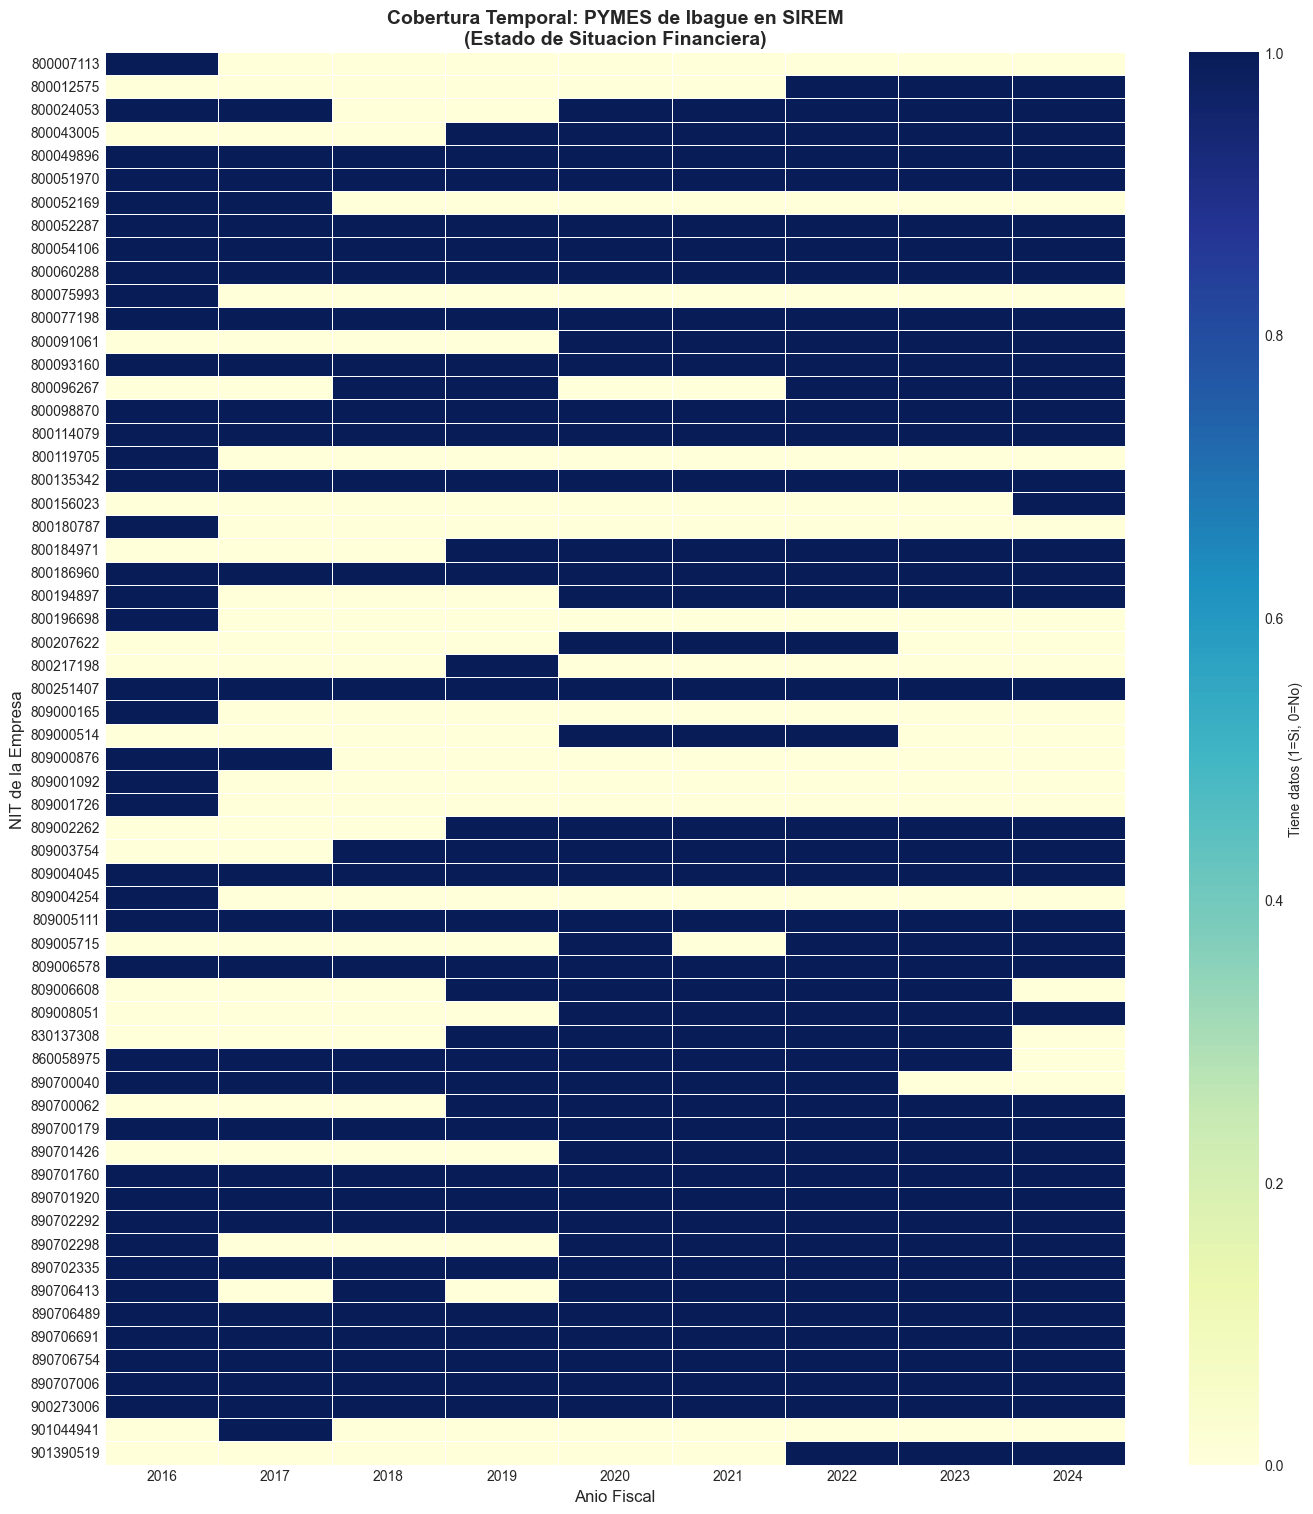

Total empresas en el mapa: 61
Total combinaciones empresa-anio con datos: 359


In [10]:
# ==============================================================================
# VISUALIZACION: MAPA DE COBERTURA TEMPORAL
# ==============================================================================

df_ref = datos_financieros['situacion_financiera']
cobertura = df_ref.groupby(['NIT_LIMPIO', 'ANIO']).size().unstack(fill_value=0)
cobertura_bin = (cobertura > 0).astype(int)

fig, ax = plt.subplots(figsize=(14, max(8, len(cobertura_bin) * 0.25)))
sns.heatmap(
    cobertura_bin,
    cmap='YlGnBu',
    cbar_kws={'label': 'Tiene datos (1=Si, 0=No)'},
    linewidths=0.5,
    ax=ax
)
ax.set_title('Cobertura Temporal: PYMES de Ibague en SIREM\n(Estado de Situacion Financiera)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Anio Fiscal', fontsize=12)
ax.set_ylabel('NIT de la Empresa', fontsize=12)
plt.tight_layout()
plt.show()

print(f'Total empresas en el mapa: {len(cobertura_bin)}')
print(f'Total combinaciones empresa-anio con datos: {cobertura_bin.sum().sum()}')

---
## 8. Conceptos Financieros Disponibles

Listamos los conceptos contables (cuentas) presentes en cada estado financiero. Estos conceptos se convertirán en **columnas** durante el pivoteo y son la base para el cálculo de indicadores financieros.

Se destacan los **conceptos clave** necesarios para calcular los indicadores de liquidez, rentabilidad, endeudamiento y eficiencia.

In [11]:
# ==============================================================================
# CONCEPTOS FINANCIEROS POR DATASET
# ==============================================================================

# Conceptos clave para indicadores financieros
CONCEPTOS_CLAVE = {
    'situacion_financiera': [
        'Activos corrientes totales',
        'Pasivos corrientes totales',
        'Total pasivos',
        'Patrimonio total',
        'Total de activos',
        'Inventarios corrientes',
        'Efectivo y equivalentes al efectivo',
    ],
    'resultado_integral': [
        'Ingresos de actividades ordinarias',
        'Costo de ventas',
        'Ganancia bruta',
        'Ganancia (p',  # Puede tener encoding variable
        'Costos financieros',
    ],
    'flujo_efectivo': [
        'Flujos de efectivo netos procedentes de (utilizados en) actividades de operaci',
    ]
}

print('CONCEPTOS FINANCIEROS POR DATASET')
print('=' * 65)

for nombre, df in datos_financieros.items():
    conceptos = sorted(df['CONCEPTO'].unique())
    claves = CONCEPTOS_CLAVE.get(nombre, [])
    print(f'\n>>> {nombre} ({len(conceptos)} conceptos):')
    for i, concepto in enumerate(conceptos, 1):
        # Marcar conceptos clave para indicadores
        es_clave = any(c.lower() in concepto.lower() for c in claves)
        marca = ' <<<< CLAVE' if es_clave else ''
        print(f'  {i:3d}. {concepto}{marca}')

CONCEPTOS FINANCIEROS POR DATASET

>>> situacion_financiera (80 conceptos):
    1. Acciones propias en cartera
    2. Activos
    3. Activos biolï¿½gicos corrientes, al costo menos depreciaciï¿½n acumulada y deterioro de valor
    4. Activos biolï¿½gicos corrientes, al valor razonable
    5. Activos biolï¿½gicos no corrientes, al costo menos depreciaciï¿½n acumulada y deterioro del valor
    6. Activos biolï¿½gicos no corrientes, al valor razonable
    7. Activos corrientes
    8. Activos corrientes distintos al efectivo pignorados como garantï¿½a colateral para la cual el receptor de la transferencia tiene derecho por contrato o costumbre a vender o pignorar nuevamente la garantï¿½a colateral
    9. Activos corrientes distintos al efectivo pignorados como garantï¿½a colateral para las que el receptor de transferencias tiene derecho por contrato o costumbre a vender o pignorar de nuevo dicha garantï¿½a colateral
   10. Activos corrientes totales <<<< CLAVE
   11. Activos intangibles di

---
## 9. Verificación de Duplicados

Antes del pivoteo, verificamos si existen combinaciones NIT + AÑO + CONCEPTO con más de un registro. Los duplicados se manejarán con `aggfunc='first'` en el pivoteo (se conserva el primer valor encontrado).

In [12]:
# ==============================================================================
# VERIFICACION DE DUPLICADOS
# ==============================================================================

print('DUPLICADOS ANTES DEL PIVOTEO')
print('=' * 65)
print('(Combinaciones NIT + ANIO + CONCEPTO con mas de 1 registro)')

for nombre, df in datos_financieros.items():
    duplicados = df.groupby(['NIT_LIMPIO', 'ANIO', 'CONCEPTO']).size()
    n_dup = (duplicados > 1).sum()
    n_total = len(duplicados)
    pct = n_dup / n_total * 100 if n_total > 0 else 0

    print(f'\n  {nombre}: {n_dup:,} duplicados de {n_total:,} combinaciones ({pct:.1f}%)')
    if n_dup > 0:
        print(f'    Ejemplos:')
        for idx, count in duplicados[duplicados > 1].head(3).items():
            print(f'      NIT={idx[0]}, ANIO={idx[1]}, CONCEPTO="{idx[2][:50]}": {count} registros')
        print(f'    Estrategia: pivot_table con aggfunc="first" (conservar primer valor)')

DUPLICADOS ANTES DEL PIVOTEO
(Combinaciones NIT + ANIO + CONCEPTO con mas de 1 registro)

  situacion_financiera: 1,625 duplicados de 11,285 combinaciones (14.4%)
    Ejemplos:
      NIT=800012575, ANIO=2022, CONCEPTO="Activos corrientes totales": 2 registros
      NIT=800012575, ANIO=2022, CONCEPTO="Capital emitido": 2 registros
      NIT=800012575, ANIO=2022, CONCEPTO="Cuentas comerciales por cobrar y otras cuentas por": 2 registros
    Estrategia: pivot_table con aggfunc="first" (conservar primer valor)

  resultado_integral: 660 duplicados de 4,650 combinaciones (14.2%)
    Ejemplos:
      NIT=800012575, ANIO=2022, CONCEPTO="Costo de ventas": 2 registros
      NIT=800012575, ANIO=2022, CONCEPTO="Costos financieros": 2 registros
      NIT=800012575, ANIO=2022, CONCEPTO="Ganancia (pï¿½rdida)": 2 registros
    Estrategia: pivot_table con aggfunc="first" (conservar primer valor)

  flujo_efectivo: 1,289 duplicados de 7,038 combinaciones (18.3%)
    Ejemplos:
      NIT=800007113, ANIO=2

---
## 10. Pivoteo de Datos: Formato Vertical → Horizontal

La transformación central del ETL. Actualmente cada fila es **un concepto contable** con su valor:

| NIT | ANIO | CONCEPTO | VALOR |
|-----|------|----------|-------|
| 890702298 | 2023 | Activos corrientes totales | 1,500,000 |
| 890702298 | 2023 | Pasivos corrientes totales | 800,000 |

Después del pivoteo, cada fila representa **una empresa en un año**, con una columna por concepto:

| NIT | ANIO | Activos corrientes totales | Pasivos corrientes totales |
|-----|------|---------------------------|---------------------------|
| 890702298 | 2023 | 1,500,000 | 800,000 |

Este formato es necesario para:
1. **Calcular indicadores financieros** (operaciones entre columnas)
2. **Entrenar modelos de ML** (cada fila = una observación, cada columna = un feature)

In [13]:
# ==============================================================================
# PIVOTEO VERTICAL -> HORIZONTAL
# ==============================================================================

def pivotar_estado_financiero(df, nombre):
    """
    Transforma un dataset del formato vertical (concepto-valor) al horizontal.

    - Index: NIT_LIMPIO + ANIO (identifica una empresa en un anio)
    - Columnas: cada CONCEPTO unico se convierte en una columna
    - Valores: VALOR numerico de cada concepto
    - Duplicados: se resuelven con aggfunc='first'
    """
    print(f'\n>>> Pivotando: {nombre}')
    print(f'    Entrada: {len(df):,} filas, {df["NIT_LIMPIO"].nunique()} empresas, '
          f'{df["CONCEPTO"].nunique()} conceptos')

    # Asegurar que VALOR sea numerico
    df['VALOR'] = pd.to_numeric(df['VALOR'], errors='coerce')

    # Pivotear: cada concepto se convierte en una columna
    pivotado = df.pivot_table(
        index=['NIT_LIMPIO', 'ANIO'],
        columns='CONCEPTO',
        values='VALOR',
        aggfunc='first'  # Resuelve duplicados conservando el primer valor
    ).reset_index()

    pivotado.columns.name = None  # Limpiar nombre del eje de columnas

    # Estadisticas del resultado
    n_conceptos = len(pivotado.columns) - 2  # Excluir NIT_LIMPIO y ANIO
    n_filas = len(pivotado)
    n_valores = pivotado.iloc[:, 2:].notna().sum().sum()
    n_total = n_conceptos * n_filas
    completitud = (n_valores / n_total * 100) if n_total > 0 else 0

    print(f'    Salida:  {n_filas:,} filas (empresa-anio), {len(pivotado.columns)} columnas')
    print(f'    Empresas: {pivotado["NIT_LIMPIO"].nunique()}, '
          f'Anios: {sorted(pivotado["ANIO"].dropna().unique().tolist())}')
    print(f'    Completitud: {completitud:.1f}% ({n_valores:,} valores de {n_total:,} posibles)')

    return pivotado

# Ejecutar pivoteo para los 3 estados financieros
print('PIVOTEO DE LOS 3 ESTADOS FINANCIEROS')
print('=' * 65)

datos_pivotados = {}
for nombre, df in datos_financieros.items():
    datos_pivotados[nombre] = pivotar_estado_financiero(df, nombre)

# Resumen
print(f'\n{"=" * 65}')
print('RESUMEN DEL PIVOTEO')
print('=' * 65)
for nombre, df in datos_pivotados.items():
    print(f'  {nombre}: {df.shape[0]} filas x {df.shape[1]} columnas')

PIVOTEO DE LOS 3 ESTADOS FINANCIEROS

>>> Pivotando: situacion_financiera
    Entrada: 13,041 filas, 61 empresas, 80 conceptos
    Salida:  359 filas (empresa-anio), 82 columnas
    Empresas: 61, Anios: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    Completitud: 39.3% (11,285 valores de 28,720 posibles)

>>> Pivotando: resultado_integral
    Entrada: 5,362 filas, 61 empresas, 22 conceptos
    Salida:  359 filas (empresa-anio), 24 columnas
    Empresas: 61, Anios: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    Completitud: 58.9% (4,650 valores de 7,898 posibles)

>>> Pivotando: flujo_efectivo
    Entrada: 8,510 filas, 61 empresas, 101 conceptos
    Salida:  359 filas (empresa-anio), 103 columnas
    Empresas: 61, Anios: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    Completitud: 19.4% (7,038 valores de 36,259 posibles)

RESUMEN DEL PIVOTEO
  situacion_financiera: 359 filas x 82 columnas
  resultado_integral: 359 filas x 24 columnas
  flujo_efectivo: 3

In [14]:
# ==============================================================================
# MUESTRA DEL ESTADO DE SITUACION FINANCIERA PIVOTADO
# ==============================================================================

df_pivot_sf = datos_pivotados['situacion_financiera']

print('COLUMNAS DEL ESTADO DE SITUACION FINANCIERA')
print('=' * 65)
for i, col in enumerate(df_pivot_sf.columns, 1):
    print(f'  {i:3d}. {col}')

print(f'\nPrimeras 5 filas:')
display(df_pivot_sf.head())

COLUMNAS DEL ESTADO DE SITUACION FINANCIERA
    1. NIT_LIMPIO
    2. ANIO
    3. Acciones propias en cartera
    4. Activos
    5. Activos biolï¿½gicos corrientes, al costo menos depreciaciï¿½n acumulada y deterioro de valor
    6. Activos biolï¿½gicos corrientes, al valor razonable
    7. Activos biolï¿½gicos no corrientes, al costo menos depreciaciï¿½n acumulada y deterioro del valor
    8. Activos biolï¿½gicos no corrientes, al valor razonable
    9. Activos corrientes
   10. Activos corrientes distintos al efectivo pignorados como garantï¿½a colateral para la cual el receptor de la transferencia tiene derecho por contrato o costumbre a vender o pignorar nuevamente la garantï¿½a colateral
   11. Activos corrientes distintos al efectivo pignorados como garantï¿½a colateral para las que el receptor de transferencias tiene derecho por contrato o costumbre a vender o pignorar de nuevo dicha garantï¿½a colateral
   12. Activos corrientes totales
   13. Activos intangibles distintos de la

,NIT_LIMPIO,ANIO,Acciones propias en cartera,Activos,"Activos biolï¿½gicos corrientes, al costo menos depreciaciï¿½n acumulada y deterioro de valor","Activos biolï¿½gicos corrientes, al valor razonable","Activos biolï¿½gicos no corrientes, al costo menos depreciaciï¿½n acumulada y deterioro del valor","Activos biolï¿½gicos no corrientes, al valor razonable",Activos corrientes,Activos corrientes distintos al efectivo pignorados como garantï¿½a colateral para la cual el receptor de la transferencia tiene derecho por contrato o costumbre a vender o pignorar nuevamente la garantï¿½a colateral,Activos corrientes distintos al efectivo pignorados como garantï¿½a colateral para las que el receptor de transferencias tiene derecho por contrato o costumbre a vender o pignorar de nuevo dicha garantï¿½a colateral,Activos corrientes totales,Activos intangibles distintos de la plusvalï¿½a,Activos no corrientes,Activos no corrientes distintos al efectivo pignorados como garantï¿½a colateral para la cual el receptor de la transferencia tiene derecho por contrato o costumbre a vender o pignorar nuevamente la garantï¿½a colateral,Activos no corrientes distintos al efectivo pignorados como garantï¿½a colateral para las que el receptor de transferencias tiene derecho por contrato o costumbre a vender o pignorar de nuevo dicha garantï¿½a colateral,Activos no corrientes o grupos de activos para su disposiciï¿½n clasificados como mantenidos para la venta o como mantenidos para distribuir a los propietarios,"Activos por impuestos corrientes, corriente","Activos por impuestos corrientes, no corriente",Activos por impuestos diferidos,Capital emitido,Cuentas comerciales por cobrar y otras cuentas por cobrar corrientes,Cuentas comerciales por cobrar y otras cuentas por cobrar no corrientes,Cuentas comerciales por pagar y otras cuentas por pagar no corrientes,Cuentas por pagar comerciales y otras cuentas por pagar,Cuentas por pagar comerciales y otras cuentas por pagar corrientes,Disposiciones actuales,Efectivo y equivalentes al efectivo,Ganancias acumuladas,Inventarios corrientes,Inventarios no corrientes,Inversiones en asociadas,Inversiones en negocios conjuntos,Inversiones en subsidiarias,Inversiï¿½n suplementaria al capital asignado,Otras participaciones en el patrimonio,Otras provisiones corrientes,Otras provisiones no corrientes,Otras reservas,Otros activos financieros corrientes,Otros activos financieros no corrientes,Otros activos no financieros corrientes,Otros activos no financieros no corrientes,Otros pasivos financieros corrientes,Otros pasivos financieros no corrientes,Otros pasivos no financieros corrientes,Otros pasivos no financieros no corrientes,Parte corriente de prï¿½stamos no corrientes,Parte no corriente de prï¿½stamos no corrientes,Participaciones no controladoras,Pasivo por impuestos diferidos,Pasivos,Pasivos corrientes,Pasivos corrientes totales,Pasivos incluidos en grupos de activos para su disposiciï¿½n clasificados como mantenidos para la venta,Pasivos no corrientes,"Pasivos por impuestos corrientes, corriente","Pasivos por impuestos corrientes, no corriente",Patrimonio,Patrimonio atribuible a los propietarios de la controladora,Patrimonio total,Patrimonio y pasivos,Plusvalï¿½a,Prima de emisiï¿½n,Propiedades de inversiï¿½n a valor razonable con cambios en resultados,Propiedades de inversiï¿½n al costo menos depreciaciï¿½n acumulada y deterioro,"Propiedades, planta y equipo",Provisiones corrientes por beneficios a los empleados,Provisiones no corrientes,Provisiones no corrientes por beneficios a los empleados,Prï¿½stamos corrientes,Superavit por revaluaciï¿½n,Total activos corrientes distintos de los activos no corrientes o grupo de activos para su disposiciï¿½n clasificados como mantenidos para la venta o como mantenidos para distribuir a los propietarios,Total de activos,Total de activos no corrientes,Total de pasivos no corrientes,Total de patrimonio y pasivos,Total pasivos,Total pasivos corrientes distintos de los pasivos inc

---
## 11. Consolidación del Dataset Final

Unimos los 3 estados financieros pivotados en un único dataset por empresa-año, y agregamos la información de la empresa desde la Cámara de Comercio (razón social, tipo de organización, actividad económica, etc.).

Este dataset consolidado será:
- La **base para el cálculo de indicadores financieros** (siguiente fase)
- La **fuente de features** para el modelo de Machine Learning

In [15]:
# ==============================================================================
# CONSOLIDACION DE LOS 3 ESTADOS FINANCIEROS
# ==============================================================================

print('CONSOLIDACION')
print('=' * 65)

# Merge de los 3 estados financieros sobre NIT_LIMPIO + ANIO
# Usamos outer join para conservar todas las combinaciones empresa-anio
# aunque falte alguno de los estados financieros
consolidado = datos_pivotados['situacion_financiera'].merge(
    datos_pivotados['resultado_integral'],
    on=['NIT_LIMPIO', 'ANIO'],
    how='outer',
    suffixes=('', '_resultado')
).merge(
    datos_pivotados['flujo_efectivo'],
    on=['NIT_LIMPIO', 'ANIO'],
    how='outer',
    suffixes=('', '_flujo')
)

print(f'Dataset consolidado (3 estados): {consolidado.shape[0]} filas x {consolidado.shape[1]} columnas')

# Verificar columnas duplicadas (conceptos que aparecen en mas de un estado)
cols_sufijo = [c for c in consolidado.columns if c.endswith('_resultado') or c.endswith('_flujo')]
if cols_sufijo:
    print(f'\nConceptos compartidos entre estados (renombrados con sufijo): {len(cols_sufijo)}')
    for col in cols_sufijo:
        print(f'  - {col}')

# Agregar informacion de la Camara de Comercio
print(f'\n--- Agregando informacion de la Camara de Comercio ---')

# Seleccionar columnas relevantes
cols_empresa = ['NIT_PARA_JOIN', 'RAZON SOCIAL', 'ORGANIZACION', 'CATEGORIA']
col_ciiu = [c for c in df_camara.columns if 'CIIU' in c.upper() or 'ACTIVIDAD' in c.upper()]
if col_ciiu:
    cols_empresa.append(col_ciiu[0])
if 'GRUPO NIIF' in df_camara.columns:
    cols_empresa.append('GRUPO NIIF')

# Info unica por empresa (evitar duplicados por multiples registros)
info_empresas = camara_validos[cols_empresa].drop_duplicates('NIT_PARA_JOIN')

# Merge con el consolidado
consolidado = consolidado.merge(
    info_empresas,
    left_on='NIT_LIMPIO',
    right_on='NIT_PARA_JOIN',
    how='left'
)
if 'NIT_PARA_JOIN' in consolidado.columns:
    consolidado.drop(columns=['NIT_PARA_JOIN'], inplace=True)

# Reordenar: informacion de empresa al inicio
cols_info = ['NIT_LIMPIO', 'RAZON SOCIAL', 'ORGANIZACION']
cols_extras = [c for c in consolidado.columns
               if c in ['CATEGORIA', 'GRUPO NIIF', 'ANIO'] + col_ciiu]
cols_financieras = [c for c in consolidado.columns
                    if c not in cols_info + cols_extras]
consolidado = consolidado[cols_info + cols_extras + cols_financieras]

print(f'\nDataset consolidado FINAL: {consolidado.shape[0]} filas x {consolidado.shape[1]} columnas')
print(f'Empresas unicas: {consolidado["NIT_LIMPIO"].nunique()}')
print(f'Rango temporal: {consolidado["ANIO"].min()} - {consolidado["ANIO"].max()}')

CONSOLIDACION
Dataset consolidado (3 estados): 359 filas x 205 columnas

Conceptos compartidos entre estados (renombrados con sufijo): 1
  - Ganancia (pï¿½rdida)_flujo

--- Agregando informacion de la Camara de Comercio ---

Dataset consolidado FINAL: 359 filas x 210 columnas
Empresas unicas: 61
Rango temporal: 2016 - 2024


---
## 12. Estadísticas del Dataset Consolidado

In [16]:
# ==============================================================================
# ESTADISTICAS DEL DATASET CONSOLIDADO
# ==============================================================================

print('RESUMEN DEL DATASET CONSOLIDADO')
print('=' * 65)

print(f'\nDimensiones: {consolidado.shape[0]} filas x {consolidado.shape[1]} columnas')
print(f'Empresas unicas: {consolidado["NIT_LIMPIO"].nunique()}')
print(f'Rango temporal: {consolidado["ANIO"].min()} - {consolidado["ANIO"].max()}')

# Observaciones por anio
print(f'\nObservaciones por anio:')
for anio, count in consolidado.groupby('ANIO').size().sort_index().items():
    print(f'  {anio}: {count} empresa-anio')

# Top empresas por cobertura
print(f'\nEmpresas con mayor cobertura temporal (Top 10):')
obs = consolidado.groupby(['NIT_LIMPIO', 'RAZON SOCIAL']).size().reset_index(name='anios')
obs = obs.sort_values('anios', ascending=False)
display(obs.head(10))

# Distribucion por tipo de organizacion
print(f'\nDistribucion por tipo de organizacion:')
org_dist = consolidado.drop_duplicates('NIT_LIMPIO')['ORGANIZACION'].value_counts()
for org, count in org_dist.items():
    print(f'  {org}: {count}')

RESUMEN DEL DATASET CONSOLIDADO

Dimensiones: 359 filas x 210 columnas
Empresas unicas: 61
Rango temporal: 2016 - 2024

Observaciones por anio:
  2016: 42 empresa-anio
  2017: 31 empresa-anio
  2018: 30 empresa-anio
  2019: 36 empresa-anio
  2020: 44 empresa-anio
  2021: 43 empresa-anio
  2022: 47 empresa-anio
  2023: 44 empresa-anio
  2024: 42 empresa-anio

Empresas con mayor cobertura temporal (Top 10):


,NIT_LIMPIO,RAZON SOCIAL,anios
46,890700179,COMPANIA AUTOMOTORA DEL TOLIMA COLTOLIMA LTDA,9
15,800098870,VENTAS DEL TOLIMA S.A.S.,9
35,809004045,FIBRATELA S.A.,9
27,800251407,AGROPECUARIA LA PILAR SAS,9
52,890702335,CENTRAL PECUARIA S.A.,9
48,890701760,JOSE I. DIAZ M. Y CIA. DIAGROTOL S. EN C.,9
37,809005111,INVERSIONES Y CONSTRUCCIONES DURAN CUELLAR S.A.S,9
22,800186960,ALTIPAL S.A.S - AGENCIA IBAGUE,9
39,809006578,ENRED GROUP SAS,9
54,890706489,DISTRIBUCIONES ZUBIETA Y CIA S.A.S.,9



Distribucion por tipo de organizacion:
  S.A.S: 37
  SOCIEDAD ANONIMA: 11
  SOCIEDAD LIMITADA: 10
  SOCIEDAD EN COMANDITA: 2
  ESTABLECIMIENTO DE COMERCIO: 1


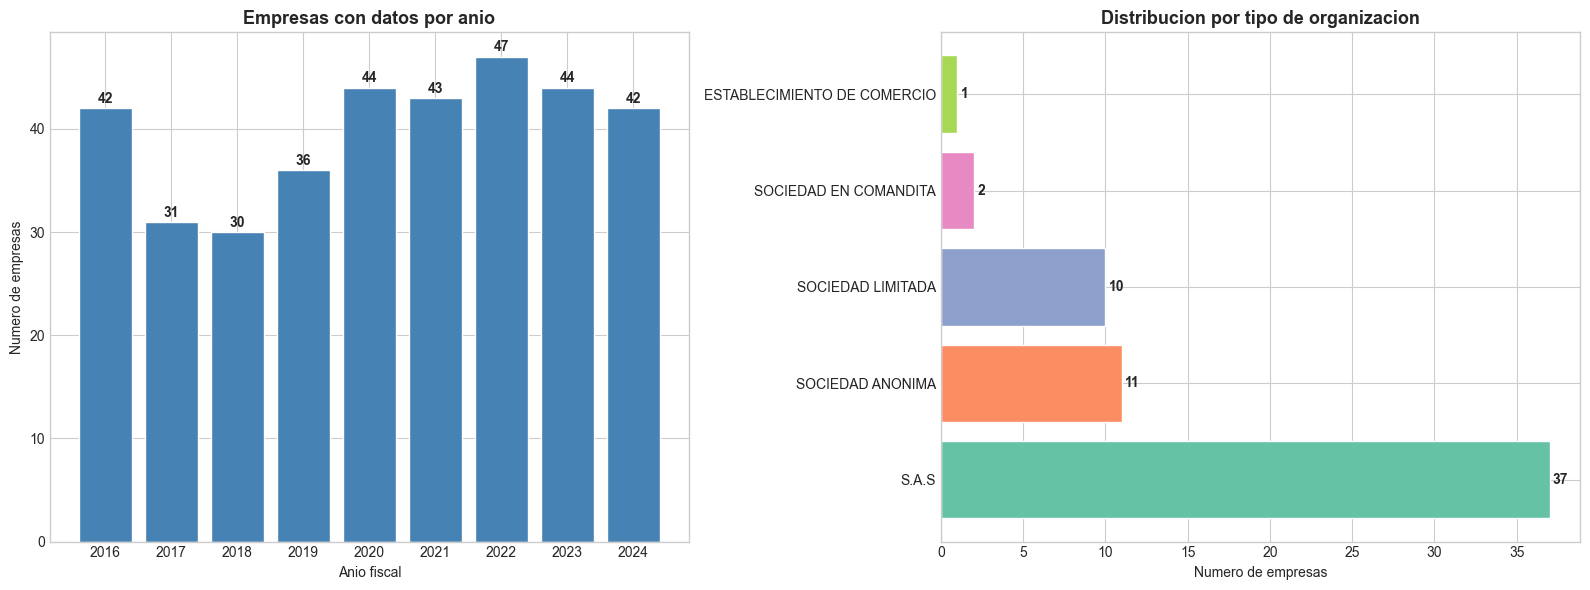

In [17]:
# ==============================================================================
# VISUALIZACIONES DEL DATASET
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafico 1: Empresas por anio
empresas_anio = consolidado.groupby('ANIO')['NIT_LIMPIO'].nunique()
axes[0].bar(empresas_anio.index.astype(str), empresas_anio.values, color='steelblue', edgecolor='white')
axes[0].set_title('Empresas con datos por anio', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Anio fiscal')
axes[0].set_ylabel('Numero de empresas')
for i, v in enumerate(empresas_anio.values):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Grafico 2: Distribucion por tipo de organizacion
org = consolidado.drop_duplicates('NIT_LIMPIO')['ORGANIZACION'].value_counts()
colors = plt.cm.Set2(range(len(org)))
axes[1].barh(org.index, org.values, color=colors, edgecolor='white')
axes[1].set_title('Distribucion por tipo de organizacion', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Numero de empresas')
for i, v in enumerate(org.values):
    axes[1].text(v + 0.2, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [18]:
# ==============================================================================
# COMPARACION CON VERSION 1.0
# ==============================================================================

print('COMPARACION v1.0 vs v2.0')
print('=' * 65)

# Resultados de la version 1.0 (hardcoded para comparacion)
v1 = {
    'filas_total': 180,
    'empresas_total': 57,
    'anio_min': 2016,
    'anio_max': 2020,
    'filas_balance': 107,
    'empresas_balance': 45,
    'anios_balance': '2018-2020',
    'filas_resultado': 107,
    'filas_flujo': 180,
}

v2 = {
    'filas_total': len(consolidado),
    'empresas_total': consolidado['NIT_LIMPIO'].nunique(),
    'anio_min': int(consolidado['ANIO'].min()),
    'anio_max': int(consolidado['ANIO'].max()),
    'filas_balance': len(datos_pivotados['situacion_financiera']),
    'empresas_balance': datos_pivotados['situacion_financiera']['NIT_LIMPIO'].nunique(),
    'anios_balance': f'{int(datos_pivotados["situacion_financiera"]["ANIO"].min())}-{int(datos_pivotados["situacion_financiera"]["ANIO"].max())}',
    'filas_resultado': len(datos_pivotados['resultado_integral']),
    'filas_flujo': len(datos_pivotados['flujo_efectivo']),
}

print(f'\n{"Metrica":<40} {"v1.0":>10} {"v2.0":>10} {"Cambio":>12}')
print(f'{"-"*72}')

metricas = [
    ('Filas totales (consolidado)', v1['filas_total'], v2['filas_total']),
    ('Empresas unicas', v1['empresas_total'], v2['empresas_total']),
    ('Rango temporal', f"{v1['anio_min']}-{v1['anio_max']}", f"{v2['anio_min']}-{v2['anio_max']}"),
    ('Filas Balance (pivotado)', v1['filas_balance'], v2['filas_balance']),
    ('Empresas en Balance', v1['empresas_balance'], v2['empresas_balance']),
    ('Anios en Balance', v1['anios_balance'], v2['anios_balance']),
    ('Filas Resultado (pivotado)', v1['filas_resultado'], v2['filas_resultado']),
    ('Filas Flujo Efectivo (pivotado)', v1['filas_flujo'], v2['filas_flujo']),
]

for metrica, val1, val2 in metricas:
    if isinstance(val1, (int, float)) and isinstance(val2, (int, float)):
        cambio = val2 - val1
        signo = '+' if cambio >= 0 else ''
        pct = f' ({signo}{cambio/val1*100:.0f}%)' if val1 > 0 else ''
        print(f'{metrica:<40} {val1:>10} {val2:>10} {signo}{cambio:>5}{pct}')
    else:
        print(f'{metrica:<40} {str(val1):>10} {str(val2):>10}')

print(f'\n>>> La correccion de FECHA_CORTE y el filtro inteligente de PERIODO')
print(f'    permiten recuperar datos que la v1.0 perdia por truncacion y formato mixto.')

COMPARACION v1.0 vs v2.0

Metrica                                        v1.0       v2.0       Cambio
------------------------------------------------------------------------
Filas totales (consolidado)                     180        359 +  179 (+99%)
Empresas unicas                                  57         61 +    4 (+7%)
Rango temporal                            2016-2020  2016-2024
Filas Balance (pivotado)                        107        359 +  252 (+236%)
Empresas en Balance                              45         61 +   16 (+36%)
Anios en Balance                          2018-2020  2016-2024
Filas Resultado (pivotado)                      107        359 +  252 (+236%)
Filas Flujo Efectivo (pivotado)                 180        359 +  179 (+99%)

>>> La correccion de FECHA_CORTE y el filtro inteligente de PERIODO
    permiten recuperar datos que la v1.0 perdia por truncacion y formato mixto.


---
## 13. Guardado de Resultados

Se guardan dos tipos de archivos:

1. **Datos filtrados (formato vertical)**: Para referencia, auditoría del proceso ETL, y posible reprocesamiento
2. **Dataset consolidado (formato horizontal)**: El producto final, listo para cálculo de indicadores financieros y Machine Learning

In [19]:
# ==============================================================================
# GUARDADO DE DATASETS PROCESADOS
# ==============================================================================

print('GUARDADO DE ARCHIVOS')
print('=' * 65)

# 1. Guardar datos filtrados en formato vertical (uno por estado financiero)
for nombre, df in datos_financieros.items():
    archivo = SALIDA_PATH / f'pymes_ibague_{nombre}_vertical.csv'
    df.to_csv(archivo, index=False, encoding='utf-8')
    tamano = archivo.stat().st_size / (1024**2)
    print(f'  [OK] {archivo.name}: {len(df):,} filas ({tamano:.2f} MB)')

# 2. Guardar dataset consolidado horizontal
archivo_consolidado = SALIDA_PATH / 'pymes_ibague_consolidado.csv'
consolidado.to_csv(archivo_consolidado, index=False, encoding='utf-8')
tamano = archivo_consolidado.stat().st_size / (1024**2)
print(f'  [OK] {archivo_consolidado.name}: {len(consolidado):,} filas ({tamano:.2f} MB)')

print(f'\nTodos los archivos guardados en: {SALIDA_PATH}')

GUARDADO DE ARCHIVOS
  [OK] pymes_ibague_situacion_financiera_vertical.csv: 13,041 filas (3.06 MB)
  [OK] pymes_ibague_resultado_integral_vertical.csv: 5,362 filas (1.17 MB)
  [OK] pymes_ibague_flujo_efectivo_vertical.csv: 8,510 filas (2.18 MB)
  [OK] pymes_ibague_consolidado.csv: 359 filas (0.30 MB)

Todos los archivos guardados en: C:\Users\USUARIO1\Documents\Tesis\data


---
## 14. Conclusiones y Próximos Pasos

### Proceso completado

1. **Extracción**: Se procesaron ~30.9 millones de filas de los 3 datasets SIREM, extrayendo las filas correspondientes a las 61 PYMES de Ibagué bajo NIIF Pymes.

2. **Corrección temporal**: Se usó `FECHA_CORTE` en lugar de `TAXONOMIA` para extraer el año fiscal, recuperando datos de 2021-2024 que la versión anterior perdía.

3. **Filtrado inteligente**: Se implementó un filtro de PERIODO que maneja los formatos mixtos (etiquetas vs fechas), recuperando datos de 2016-2017 para Balance y Resultados.

4. **Pivoteo**: Se transformó cada estado financiero del formato vertical (concepto-valor) al horizontal (una columna por concepto).

5. **Consolidación**: Se unieron los 3 estados financieros en un único dataset y se agregó información de la Cámara de Comercio.

### Anomalías documentadas
- **Flujo de Efectivo**: El campo PERIODO contiene NITs como valores para las entradas de 2016 (error en el dataset fuente del SIREM). Los datos financieros (VALOR) son válidos.
- **FECHA_CORTE 2022-Nov-30**: Un pequeño grupo de empresas tiene cierre en noviembre 2022 en lugar de diciembre. Se agrupan con el año 2022.

### Próximos pasos

1. **Calcular indicadores financieros**: Liquidez, rentabilidad, endeudamiento, eficiencia
2. **Crear etiquetas de riesgo** para el modelo de Machine Learning
3. **Análisis exploratorio** de los indicadores calculados
4. **Iniciar la arquitectura del sistema web** (React + Node.js + PostgreSQL)

In [ ]:
# ==============================================================================
# RESUMEN FINAL
# ==============================================================================

print('=' * 70)
print('RESUMEN FINAL DEL PROCESAMIENTO v2.0')
print('=' * 70)

print(f'\nDATOS EXTRAIDOS (formato vertical):')
for nombre, df in datos_financieros.items():
    print(f'  {nombre}: {len(df):,} filas, {df["NIT_LIMPIO"].nunique()} empresas')

print(f'\nDATASET CONSOLIDADO (formato horizontal):')
print(f'  Dimensiones: {consolidado.shape[0]} filas x {consolidado.shape[1]} columnas')
print(f'  Empresas: {consolidado["NIT_LIMPIO"].nunique()}')
print(f'  Rango temporal: {consolidado["ANIO"].min()} - {consolidado["ANIO"].max()}')

n_cols_fin = len([c for c in consolidado.columns
                  if c not in ['NIT_LIMPIO', 'RAZON SOCIAL', 'ORGANIZACION',
                               'CATEGORIA', 'GRUPO NIIF', 'ANIO']
                  and 'CIIU' not in c.upper() and 'ACTIVIDAD' not in c.upper()])
print(f'  Columnas financieras: {n_cols_fin}')

print(f'\nARCHIVOS EN: {SALIDA_PATH}')
for archivo in sorted(SALIDA_PATH.glob('pymes_ibague_*.csv')):
    tamano = archivo.stat().st_size / (1024**2)
    print(f'  {archivo.name}: {tamano:.2f} MB')

print(f'\n>>> Dataset listo para el calculo de indicadores financieros')
print(f'>>> Version 2.0 - Correccion de FECHA_CORTE aplicada')